# Panel Rendering with py-trelliscope

This notebook demonstrates how to render actual visualizations (panels) from matplotlib and plotly figures.

## Overview

Phase 2 adds the ability to render panel objects to files:
- **Matplotlib**: PNG, JPEG, SVG, PDF
- **Plotly**: Interactive HTML
- **Lazy evaluation**: Create panels on-demand with callables
- **Error handling**: Continues if individual panels fail

## Installation

```bash
pip install matplotlib plotly  # If not already installed
```

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from trelliscope import Display

## Example 1: Basic Matplotlib Panels

Create a display with matplotlib figures that are automatically rendered to PNG files.

DataFrame created with 5 panels


,panel,category,mean,std
0,Figure(600x400),A,6.409242,1.397431
1,Figure(600x400),B,13.021970,1.011044
2,Figure(600x400),C,5.745506,2.630923
3,Figure(600x400),D,14.868869,2.413715
4,Figure(600x400),E,12.722448,2.458014


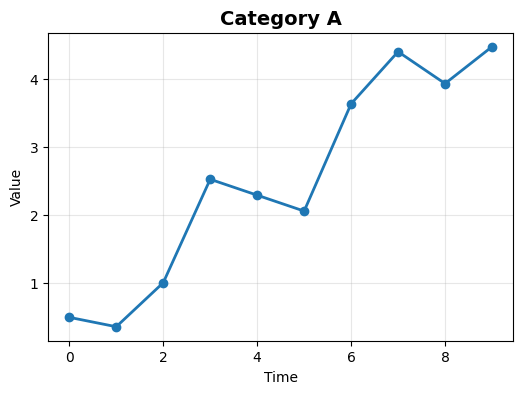

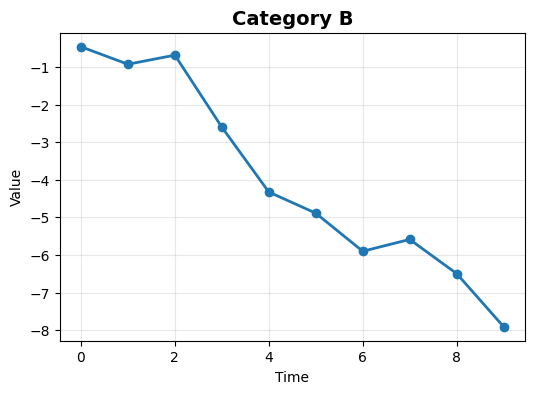

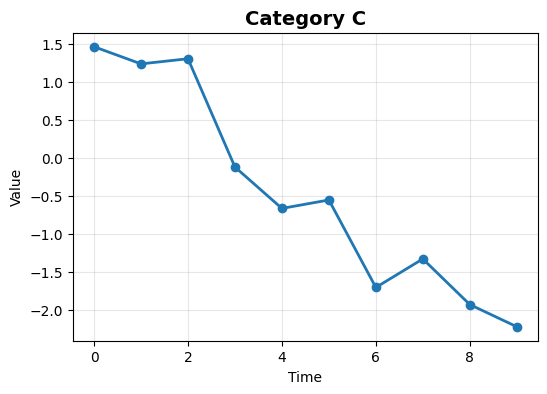

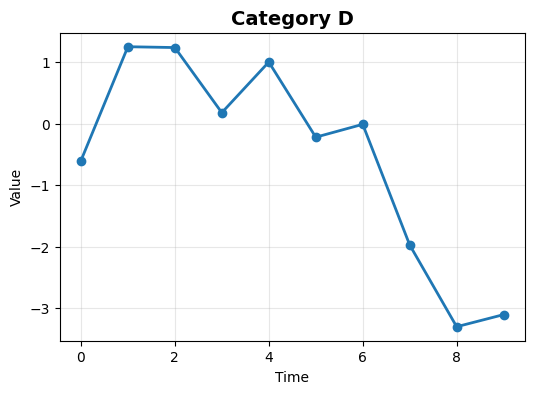

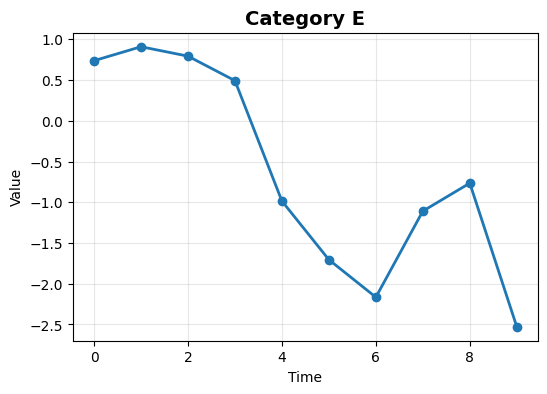

In [5]:
# Create sample data
np.random.seed(42)

# Generate matplotlib figures
def create_line_plot(category, values):
    """Create a simple line plot."""
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(values, marker='o', linewidth=2)
    ax.set_title(f'Category {category}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3)
    return fig

# Create DataFrame with figures
df = pd.DataFrame({
    'panel': [create_line_plot(cat, np.random.randn(10).cumsum()) 
              for cat in ['A', 'B', 'C', 'D', 'E']],
    'category': ['A', 'B', 'C', 'D', 'E'],
    'mean': np.random.uniform(5, 15, 5),
    'std': np.random.uniform(1, 3, 5)
})

print("DataFrame created with", len(df), "panels")
df.head()

In [6]:
# Create and write display
output = (
    Display(df, name="line_plots", description="Time series by category")
    .set_panel_column('panel')
    .infer_metas()
    .set_default_layout(ncol=3, nrow=2)
    .set_default_labels(['category', 'mean', 'std'])
    .write()
)

print(f"\nDisplay written to: {output}")
print(f"\nDirectory contents:")
for item in output.iterdir():
    if item.is_dir():
        panel_count = len(list(item.glob('*')))
        print(f"  {item.name}/ ({panel_count} files)")
    else:
        print(f"  {item.name}")

Rendering 5 panels...
  Rendered panel 0: 0.png
  Rendered panel 1: 1.png
  Rendered panel 2: 2.png
  Rendered panel 3: 3.png
  Rendered panel 4: 4.png

Display written to: trelliscope_output/line_plots

Directory contents:
  displayInfo.json
  panels/ (5 files)
  metadata.csv


## Example 2: Different Plot Types

Demonstrate various matplotlib plot types in a single display.

Created 4 different plot types


/var/folders/_6/yhy5krgn18d9n4fzp832dpr00000gn/T/ipykernel_17668/776238765.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=['A', 'B', 'C', 'D'])


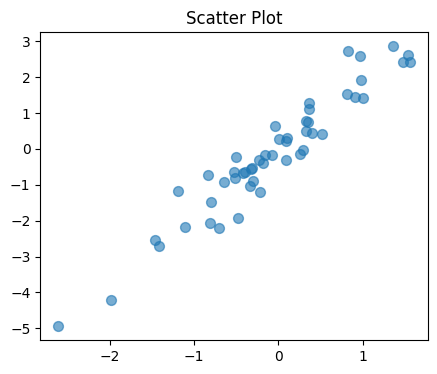

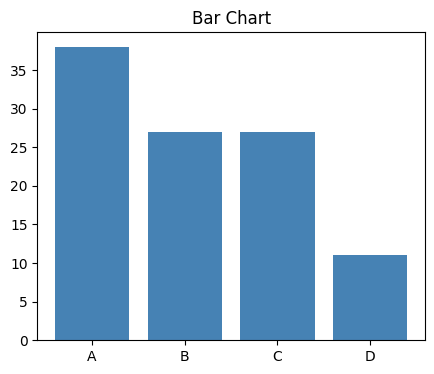

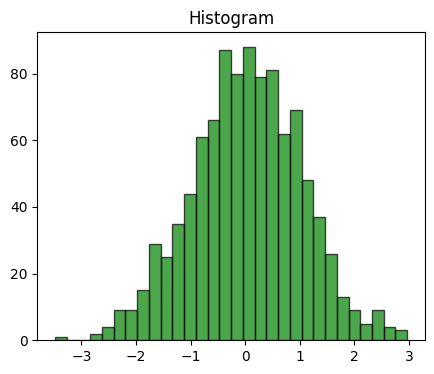

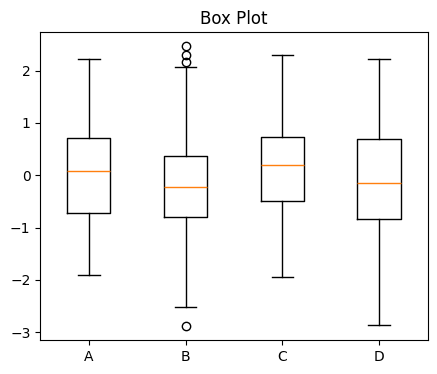

In [7]:
# Create different plot types
def create_scatter():
    fig, ax = plt.subplots(figsize=(5, 4))
    x = np.random.randn(50)
    y = 2 * x + np.random.randn(50) * 0.5
    ax.scatter(x, y, alpha=0.6, s=50)
    ax.set_title('Scatter Plot')
    return fig

def create_bar():
    fig, ax = plt.subplots(figsize=(5, 4))
    categories = ['A', 'B', 'C', 'D']
    values = np.random.randint(10, 50, 4)
    ax.bar(categories, values, color='steelblue')
    ax.set_title('Bar Chart')
    return fig

def create_histogram():
    fig, ax = plt.subplots(figsize=(5, 4))
    data = np.random.randn(1000)
    ax.hist(data, bins=30, color='green', alpha=0.7, edgecolor='black')
    ax.set_title('Histogram')
    return fig

def create_boxplot():
    fig, ax = plt.subplots(figsize=(5, 4))
    data = [np.random.randn(100) for _ in range(4)]
    ax.boxplot(data, labels=['A', 'B', 'C', 'D'])
    ax.set_title('Box Plot')
    return fig

# Create DataFrame with mixed plot types
df_mixed = pd.DataFrame({
    'panel': [create_scatter(), create_bar(), create_histogram(), create_boxplot()],
    'plot_type': ['scatter', 'bar', 'histogram', 'boxplot'],
    'complexity': ['medium', 'low', 'low', 'medium']
})

print(f"Created {len(df_mixed)} different plot types")

In [8]:
# Write display
output2 = (
    Display(df_mixed, name="mixed_plots", description="Various plot types")
    .set_panel_column('panel')
    .infer_metas()
    .set_default_layout(ncol=2, nrow=2)
    .write(force=True)
)

print(f"Display written to: {output2}")

# Verify panels
panels = list((output2 / "panels").glob("*.png"))
print(f"Generated {len(panels)} panel files")

Rendering 4 panels...
  Rendered panel 0: 0.png
  Rendered panel 1: 1.png
  Rendered panel 2: 2.png
  Rendered panel 3: 3.png
Display written to: trelliscope_output/mixed_plots
Generated 4 panel files


## Example 3: Lazy Panel Evaluation

For expensive computations, use callables to defer panel generation until write time.

In [9]:
# Define function that creates plot on-demand
def create_expensive_plot(seed, n_points=1000):
    """Simulate expensive computation."""
    def generate():
        # This only runs when write() is called
        np.random.seed(seed)
        data = np.random.randn(n_points).cumsum()
        
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.plot(data, linewidth=1.5, alpha=0.8)
        ax.set_title(f'Seed {seed} - {n_points} points')
        ax.set_xlabel('Index')
        ax.set_ylabel('Value')
        ax.grid(True, alpha=0.3)
        return fig
    return generate

# Create DataFrame with callables (NOT actual figures)
df_lazy = pd.DataFrame({
    'panel': [create_expensive_plot(i) for i in range(10)],  # Callables!
    'seed': range(10),
    'n_points': [1000] * 10
})

print("DataFrame created with callable panels (not yet rendered)")
print(f"Panel column type: {type(df_lazy['panel'].iloc[0])}")
print(f"Is callable: {callable(df_lazy['panel'].iloc[0])}")

DataFrame created with callable panels (not yet rendered)
Panel column type: <class 'function'>
Is callable: True


Starting lazy panel rendering...

Rendering 10 panels...
  Rendered panel 0: 0.png
  Rendered panel 1: 1.png
  Rendered panel 2: 2.png
  Rendered panel 3: 3.png
  Rendered panel 4: 4.png
  Rendered panel 5: 5.png
  Rendered panel 6: 6.png
  Rendered panel 7: 7.png
  Rendered panel 8: 8.png
  Rendered panel 9: 9.png

Display written to: trelliscope_output/lazy_plots
All panels rendered on-demand during write()


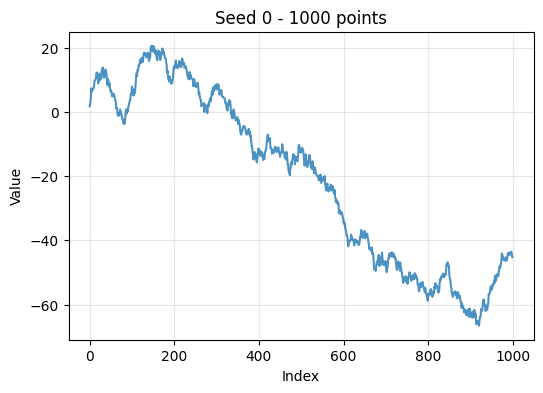

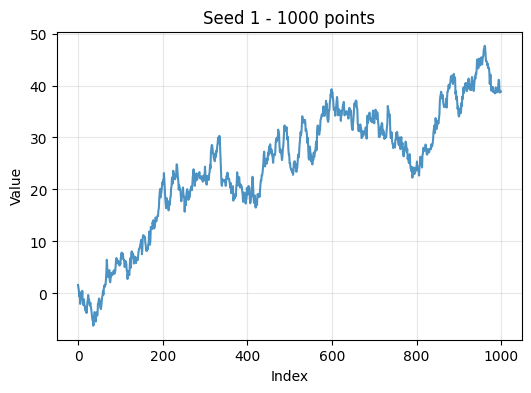

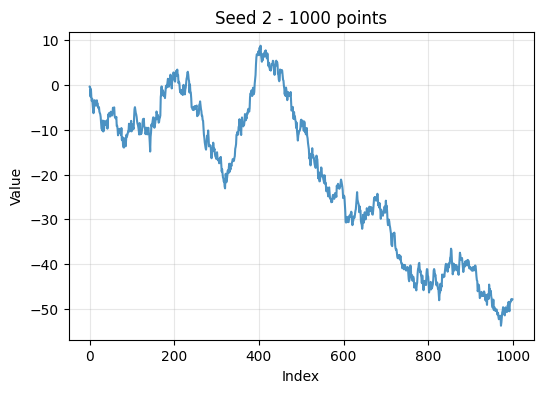

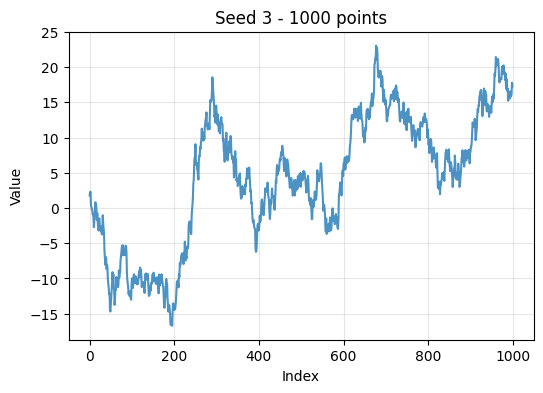

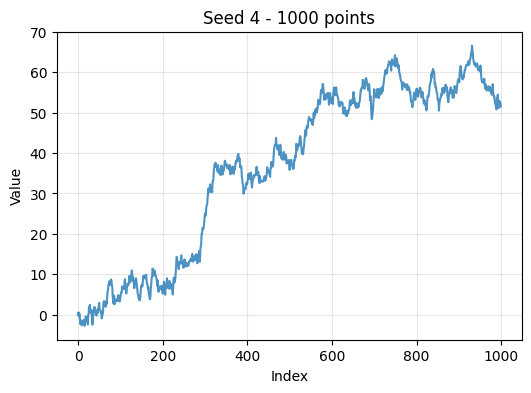

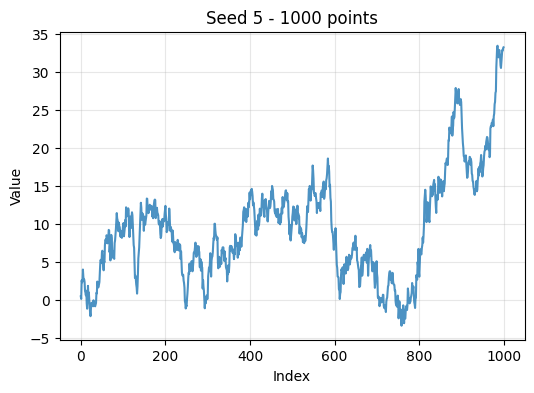

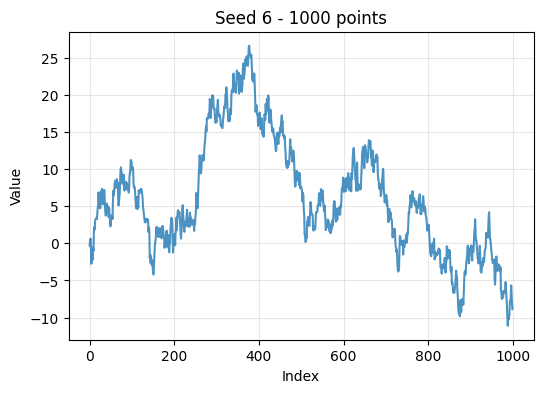

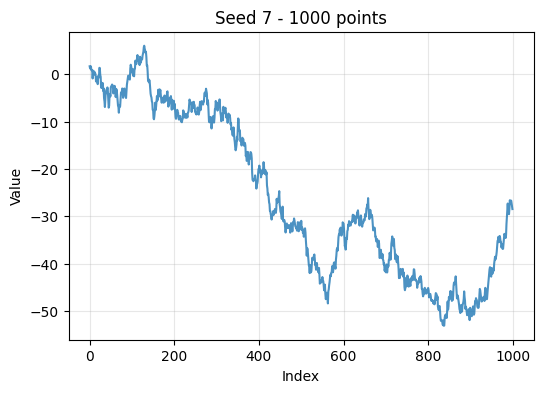

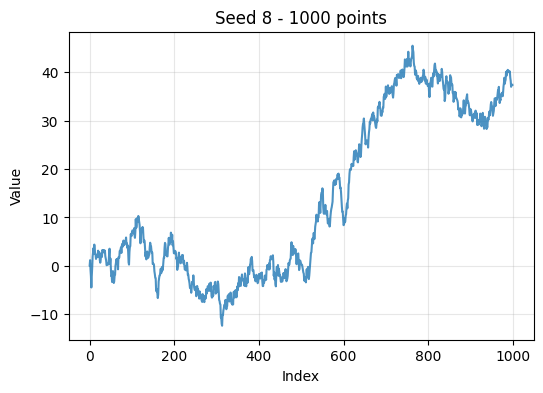

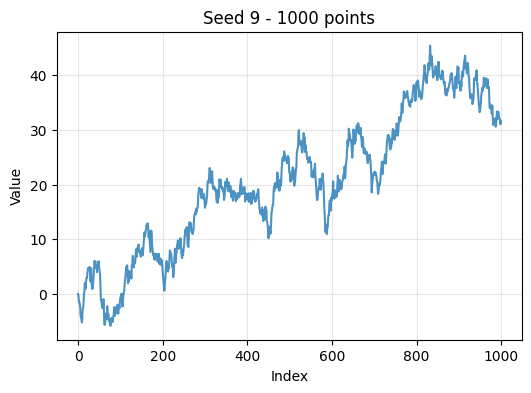

In [10]:
# Write display - callables executed during rendering
print("Starting lazy panel rendering...\n")

output3 = (
    Display(df_lazy, name="lazy_plots", description="Lazy evaluated plots")
    .set_panel_column('panel')
    .infer_metas()
    .write(force=True)
)

print(f"\nDisplay written to: {output3}")
print(f"All panels rendered on-demand during write()")

## Example 4: Plotly Interactive Panels

Use plotly for interactive HTML panels instead of static images.

In [11]:
try:
    import plotly.graph_objects as go
    plotly_available = True
except ImportError:
    print("Plotly not available. Install with: pip install plotly")
    plotly_available = False

if plotly_available:
    # Create plotly figures
    def create_plotly_scatter(n_points=100):
        x = np.random.randn(n_points)
        y = 2 * x + np.random.randn(n_points)
        
        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=x, y=y,
            mode='markers',
            marker=dict(size=8, opacity=0.6),
            name='Data'
        ))
        fig.update_layout(
            title=f'Interactive Scatter ({n_points} points)',
            xaxis_title='X',
            yaxis_title='Y',
            hovermode='closest'
        )
        return fig
    
    # Create DataFrame with plotly figures
    df_plotly = pd.DataFrame({
        'panel': [create_plotly_scatter(n) for n in [50, 100, 200]],
        'n_points': [50, 100, 200],
        'plot_type': ['plotly'] * 3
    })
    
    print("Created plotly figures")
    print(f"Panel type: {type(df_plotly['panel'].iloc[0])}")

Created plotly figures
Panel type: <class 'plotly.graph_objs._figure.Figure'>


In [12]:
if plotly_available:
    # Write display - plotly figures saved as interactive HTML
    output4 = (
        Display(df_plotly, name="plotly_plots", description="Interactive plotly panels")
        .set_panel_column('panel')
        .infer_metas()
        .write(force=True)
    )
    
    print(f"Display written to: {output4}")
    
    # Check panel format
    panels = list((output4 / "panels").glob("*.html"))
    print(f"Generated {len(panels)} HTML panel files")
    print("\nHTML panels are interactive in the browser!")

Rendering 3 panels...
  Rendered panel 0: 0.html
  Rendered panel 1: 1.html
  Rendered panel 2: 2.html
Display written to: trelliscope_output/plotly_plots
Generated 3 HTML panel files

HTML panels are interactive in the browser!


## Example 5: Conditional Rendering

Skip panel rendering to only write metadata (useful for testing).

In [13]:
# Create figures
def make_plot(i):
    fig, ax = plt.subplots()
    ax.plot([1, 2, 3], [i, i*2, i*3])
    return fig

df_skip = pd.DataFrame({
    'panel': [make_plot(i) for i in range(3)],
    'value': [10, 20, 30]
})

# Write WITHOUT rendering panels
output5 = (
    Display(df_skip, name="metadata_only", description="Metadata without panels")
    .set_panel_column('panel')
    .infer_metas()
    .write(render_panels=False, force=True)  # Skip panel rendering
)

print(f"Display written to: {output5}")
print(f"\nDirectory contents:")
for item in output5.iterdir():
    print(f"  {item.name}")

print("\nNote: No panels/ directory created!")

# Clean up matplotlib figures
for fig in df_skip['panel']:
    plt.close(fig)

Display written to: trelliscope_output/metadata_only

Directory contents:
  displayInfo.json
  metadata.csv

Note: No panels/ directory created!


## Example 6: Error Handling

Display continues rendering even if some panels fail.

DataFrame with mixed valid/invalid panels
Valid panels: 2
Invalid panels: 3


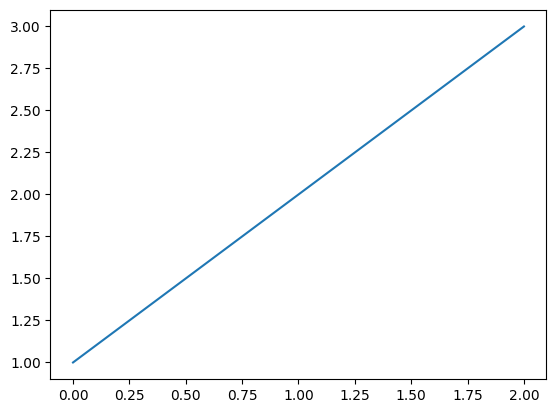

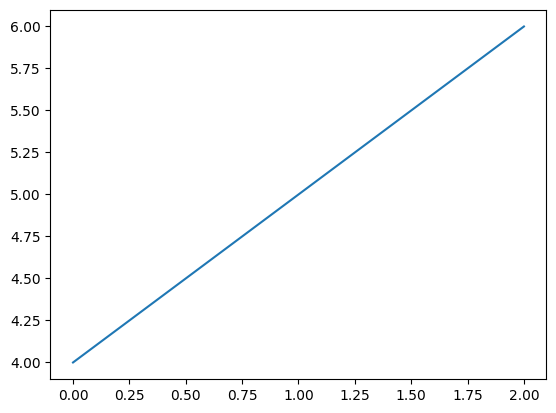

In [14]:
# Create mix of valid and invalid panels
fig1, ax1 = plt.subplots()
ax1.plot([1, 2, 3])

fig2, ax2 = plt.subplots()
ax2.plot([4, 5, 6])

df_errors = pd.DataFrame({
    'panel': [fig1, "not a figure", fig2, None, "also invalid"],
    'status': ['valid', 'invalid', 'valid', 'invalid', 'invalid']
})

print("DataFrame with mixed valid/invalid panels")
print(f"Valid panels: {(df_errors['status'] == 'valid').sum()}")
print(f"Invalid panels: {(df_errors['status'] == 'invalid').sum()}")

In [15]:
# Write display - errors logged but rendering continues
print("Rendering with errors...\n")

output6 = (
    Display(df_errors, name="with_errors", description="Panels with some errors")
    .set_panel_column('panel')
    .write(force=True)
)

# Clean up valid figures
plt.close(fig1)
plt.close(fig2)

# Check results
panels = list((output6 / "panels").glob("*.png"))
print(f"\n{len(panels)} panels successfully rendered (out of 5 total)")
print("Invalid panels were skipped, display still created!")

Rendering with errors...

Rendering 5 panels...
  Rendered panel 0: 0.png
  Error rendering panel 1: No adapter found for panel '1' of type 'str'. Supported types: matplotlib.figure.Figure, plotly.graph_objects.Figure, callable returning one of the above. You may need to install additional visualization libraries or register a custom adapter.
  Rendered panel 2: 2.png
  Error rendering panel 3: No adapter found for panel '3' of type 'NoneType'. Supported types: matplotlib.figure.Figure, plotly.graph_objects.Figure, callable returning one of the above. You may need to install additional visualization libraries or register a custom adapter.
  Error rendering panel 4: No adapter found for panel '4' of type 'str'. Supported types: matplotlib.figure.Figure, plotly.graph_objects.Figure, callable returning one of the above. You may need to install additional visualization libraries or register a custom adapter.

2 panels successfully rendered (out of 5 total)
Invalid panels were skipped, disp

## Summary

### Key Takeaways

1. **Automatic Rendering**: `Display.write()` automatically renders panel objects to files
2. **Multiple Formats**: Supports matplotlib (PNG, SVG, etc.) and plotly (HTML)
3. **Lazy Evaluation**: Use callables to defer expensive computations
4. **Error Resilience**: Rendering continues even if some panels fail
5. **Flexible**: Can skip rendering with `render_panels=False`

### Supported Panel Types

| Type | Adapter | Output Format | Example |
|------|---------|---------------|----------|
| `matplotlib.figure.Figure` | MatplotlibAdapter | PNG (default), JPEG, SVG, PDF | `plt.subplots()` |
| `plotly.graph_objects.Figure` | PlotlyAdapter | HTML (interactive) | `go.Figure()` |
| `callable` returning above | Auto-detect | Based on return type | `lambda: create_plot()` |

### Output Structure

```
display_name/
├── displayInfo.json    # Display configuration
├── metadata.csv        # Cognostics for each panel
└── panels/            # Rendered panel files
    ├── 0.png
    ├── 1.png
    └── ...
```

### Next Steps

- Explore viewer integration for interactive display browsing
- Customize panel rendering options (DPI, size, format)
- Add custom panel adapters for other visualization libraries
- Optimize rendering performance with parallel processing

In [16]:
# Clean up all figures
plt.close('all')
print("All matplotlib figures closed")

All matplotlib figures closed
